# Evaluate ERA-5 downscaling: minimum and maximum temperatures

We used **1981-1991 as training** period and **1991-2010 as reference** period. The results shown in this notebook are based on the model predictions on the reference period.

**Predictors on pressure levels (500, 850)**:
- Geopotential (z)
- Temperature (t)
- Zonal wind (u)
- Meridional wind (v)
- Specific humidity (q)

**Predictors on surface**:
- Surface pressure (p)

**Auxiliary predictors**:
- Elevation from Copernicus EU-DEM v1.1 (dem)
- Day of the year (doy)

Define the predictand and the model to evaluate:

In [1]:
# define the predictand
PREDICTAND = 'tasmean'  # 'tasmin' or 'tasmax'

In [2]:
# model filename to evaluate
FILENAME = 'RandomForest_tasmean_ztuvq_500_850_mslp_dem_sa_doy.nc'  # change me!

### Imports

In [3]:
# builtins
import datetime
import warnings
import calendar

# externals
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats as stats
from IPython.display import Image
from sklearn.metrics import r2_score

# locals
from downscaleml.main.inputoutput import ERA5_PATH, OBS_PATH, TARGET_PATH, DEM_PATH, MODEL_PATH
from climax.core.utils import plot_loss
from climax.core.dataset import ERA5Dataset
from downscaleml.core.utils import search_files

In [4]:
# mapping from predictands to variable names
NAMES = {'tasmin': 'minimum temperature', 'tasmax': 'maximum temperature', 'pr': 'precipitation', 'tasmean': 'mean temperature'}

### Model architecture

### Load datasets

In [5]:
# model predictions
y_pred = xr.open_dataset(TARGET_PATH.joinpath(PREDICTAND, FILENAME))
y_pred

<xarray.Dataset>
Dimensions:  (time: 8035, y: 38, x: 39)
Coordinates:
  * time     (time) datetime64[ns] 1995-01-01 1995-01-02 ... 2016-12-30
  * y        (y) float64 2.715e+06 2.708e+06 2.701e+06 ... 2.463e+06 2.456e+06
  * x        (x) float64 4.299e+06 4.306e+06 4.313e+06 ... 4.557e+06 4.564e+06
Data variables:
    tasmean  (time, y, x) float64 ...

In [6]:
# target values: observations
y_true = xr.open_dataset(search_files(OBS_PATH.joinpath(PREDICTAND), '.nc$').pop())
y_true

<xarray.Dataset>
Dimensions:  (time: 11688, x: 39, y: 38)
Coordinates:
  * time     (time) datetime64[ns] 1985-01-01 1985-01-02 ... 2016-12-31
  * x        (x) float64 4.299e+06 4.306e+06 4.313e+06 ... 4.557e+06 4.564e+06
  * y        (y) float64 2.715e+06 2.708e+06 2.701e+06 ... 2.463e+06 2.456e+06
Data variables:
    t2m      (time, y, x) float32 ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             Norrkoping
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    history:                 Fri May 05 16:29:19 2023: cdo remapbil,3035_tren...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [7]:
# subset to time period covered by predictions
y_true = y_true.sel(time=y_pred.time)


In [8]:
y_true = y_true.rename({'t2m': PREDICTAND})
y_true

<xarray.Dataset>
Dimensions:  (time: 8035, x: 39, y: 38)
Coordinates:
  * time     (time) datetime64[ns] 1995-01-01 1995-01-02 ... 2016-12-30
  * x        (x) float64 4.299e+06 4.306e+06 4.313e+06 ... 4.557e+06 4.564e+06
  * y        (y) float64 2.715e+06 2.708e+06 2.701e+06 ... 2.463e+06 2.456e+06
Data variables:
    tasmean  (time, y, x) float32 ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             Norrkoping
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    history:                 Fri May 05 16:29:19 2023: cdo remapbil,3035_tren...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [9]:
# align datasets and mask missing values in model predictions
y_true, y_pred = xr.align(y_true[PREDICTAND], y_pred[PREDICTAND], join='override')
y_pred = y_pred.where(~np.isnan(y_true), other=np.nan)

## Model validation

In [10]:
y_true

<xarray.DataArray 'tasmean' (time: 8035, y: 38, x: 39)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan, 273.8928 , ...,       nan,       nan],
        ...,
        [      nan, 280.5642 , ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan, 270.48157, ...,       nan,       nan],
        ...,
        [      nan, 277.2965 , ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       ...,

       [[      nan,       nan, ...,       nan,       nan],
        [      nan, 270.27753, ...,       nan,       nan],
        ...,
        [      nan, 276.92154, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan, 269.98334, ...,       nan,       nan],
        ...,
        [      nan, 273.62994, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1995-01-01 1995-01-02 ... 2016-12-30
  * x        (x) float64 4.299e+06 4.306e+06 4.313e+06 ... 4.557e+06 4.564e+06
  * y        (y) float64 2.715e+06 2.708e+06 2.701e+06 ... 2.463e+06 2.456e+06
Attributes: (12/24)
    standard_name:                            air_temperature
    long_name:                                2 metre temperature
    units:                                    K
    grid_mapping:                             spatial_ref
    GRIB_dataType:                            an
    GRIB_typeOfLevel:                         heightAboveGround
    ...                                       ...
    GRIB_latitudeOfSouthernPoleInDegrees:     -90.0
    GRIB_longitudeOfFirstGridPointInDegrees:  342.514057
    GRIB_longitudeOfSouthernPoleInDegrees:    0.0
    GRIB_name:                                2 metre temperature
    GRIB_shortName:                           2t
    GRIB_units:                               K

In [11]:
y_pred

<xarray.DataArray 'tasmean' (time: 8035, y: 38, x: 39)>
array([[[         nan,          nan,          nan, ..., 265.84034119,
                  nan,          nan],
        [         nan, 273.53745575, 272.22418549, ..., 266.48654449,
                  nan,          nan],
        [         nan, 272.6565802 , 271.65774323, ..., 268.51807739,
                  nan,          nan],
        ...,
        [         nan, 278.14963623, 278.64798187, ..., 281.9648703 ,
         281.66935486,          nan],
        [         nan, 278.52151062, 277.9089624 , ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ..., 260.80611847,
                  nan,          nan],
        [         nan, 270.40463226, 268.68869354, ..., 261.49299561,
                  nan,          nan],
        [         nan, 269.82747375, 268.19971588, ..., 263.23552582,
                  nan,          nan],
...
        [         nan, 274.99015961, 274.86579224, ..., 281.52424316,
         281.28725677,          nan],
        [         nan, 274.87006653, 274.69518585, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ..., 262.48562988,
                  nan,          nan],
        [         nan, 268.31986267, 267.7903772 , ..., 263.76683533,
                  nan,          nan],
        [         nan, 268.60414032, 268.084758  , ..., 265.90217865,
                  nan,          nan],
        ...,
        [         nan, 272.33991852, 272.02998535, ..., 280.59758575,
         281.17749298,          nan],
        [         nan, 272.34621704, 272.43452576, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1995-01-01 1995-01-02 ... 2016-12-30
  * y        (y) float64 2.715e+06 2.708e+06 2.701e+06 ... 2.463e+06 2.456e+06
  * x        (x) float64 4.299e+06 4.306e+06 4.313e+06 ... 4.557e+06 4.564e+06

In [12]:
y_pred = y_pred - 273.15
y_true = y_true - 273.15

In [13]:
# calculate monthly means
y_pred_mm = y_pred.groupby('time.month').mean(dim=('time'))
y_true_mm = y_true.groupby('time.month').mean(dim=('time'))

In [14]:
y_pred_mm

<xarray.DataArray 'tasmean' (month: 12, y: 38, x: 39)>
array([[[            nan,             nan,             nan, ...,
         -6.70269100e+00,             nan,             nan],
        [            nan, -9.30412606e-03, -1.09670722e+00, ...,
         -6.23949579e+00,             nan,             nan],
        [            nan, -2.12823083e-01, -1.36168387e+00, ...,
         -4.37284991e+00,             nan,             nan],
        ...,
        [            nan,  3.59143962e+00,  3.61084092e+00, ...,
          8.55814976e+00,  8.61544719e+00,             nan],
        [            nan,  3.67269127e+00,  3.68014370e+00, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
         -6.48911943e+00,             nan,             nan],
        [            nan,  1.22631102e-01, -1.00392335e+00, ...,
         -5.96522593e+00,             nan,             nan],
        [            nan, -1.06076440e-01, -1.27160539e+00, ...,
         -4.07374517e+00,             nan,             nan],
...
        [            nan,  8.63898195e+00,  8.68559816e+00, ...,
          1.21990755e+01,  1.22494005e+01,             nan],
        [            nan,  8.71480664e+00,  8.79769153e+00, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
         -5.69106820e+00,             nan,             nan],
        [            nan,  9.34965354e-01, -1.44483582e-01, ...,
         -5.26274034e+00,             nan,             nan],
        [            nan,  7.32815005e-01, -4.50673120e-01, ...,
         -3.50713269e+00,             nan,             nan],
        ...,
        [            nan,  4.48411745e+00,  4.52210697e+00, ...,
          9.14496997e+00,  9.20095132e+00,             nan],
        [            nan,  4.55155655e+00,  4.59414788e+00, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]]])
Coordinates:
  * y        (y) float64 2.715e+06 2.708e+06 2.701e+06 ... 2.463e+06 2.456e+06
  * x        (x) float64 4.299e+06 4.306e+06 4.313e+06 ... 4.557e+06 4.564e+06
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [15]:
y_true_mm

<xarray.DataArray 'tasmean' (month: 12, y: 38, x: 39)>
array([[[        nan,         nan,         nan, ..., -7.5024467 ,
                 nan,         nan],
        [        nan, -0.7528546 , -1.7669837 , ..., -6.9768806 ,
                 nan,         nan],
        [        nan, -0.83706343, -1.9440761 , ..., -5.129619  ,
                 nan,         nan],
        ...,
        [        nan,  2.5170872 ,  2.5396776 , ...,  7.5719805 ,
          7.7073092 ,         nan],
        [        nan,  2.5821404 ,  2.5767837 , ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., -6.766826  ,
                 nan,         nan],
        [        nan,  0.3148695 , -0.8589827 , ..., -6.1404033 ,
                 nan,         nan],
        [        nan,  0.05618311, -1.2180676 , ..., -4.1487904 ,
                 nan,         nan],
...
        [        nan,  8.170534  ,  8.243488  , ..., 13.076615  ,
         13.17313   ,         nan],
        [        nan,  8.252582  ,  8.298256  , ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., -6.023795  ,
                 nan,         nan],
        [        nan,  0.05954132, -0.8750032 , ..., -5.7477818 ,
                 nan,         nan],
        [        nan, -0.06964663, -1.0365703 , ..., -4.1062884 ,
                 nan,         nan],
        ...,
        [        nan,  3.176575  ,  3.2029676 , ...,  9.178733  ,
          9.310358  ,         nan],
        [        nan,  3.2873633 ,  3.2857208 , ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * x        (x) float64 4.299e+06 4.306e+06 4.313e+06 ... 4.557e+06 4.564e+06
  * y        (y) float64 2.715e+06 2.708e+06 2.701e+06 ... 2.463e+06 2.456e+06
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [16]:
# calculate mean annual cycle
y_pred_ac = y_pred_mm.mean(dim=('x', 'y'))
y_true_ac = y_true_mm.mean(dim=('x', 'y'))

In [17]:
# compute daily anomalies
y_pred_anom = ERA5Dataset.anomalies(y_pred, timescale='time.month')
y_true_anom = ERA5Dataset.anomalies(y_true, timescale='time.month')

### Coefficient of determination

In [18]:
# get predicted and observed daily anomalies
y_pred_av = y_pred_anom.values.flatten()
y_true_av = y_true_anom.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_av) & ~np.isnan(y_true_av))
y_pred_av = y_pred_av[mask]
y_true_av = y_true_av[mask]

# get predicted and observed monthly means
y_pred_mv = y_pred_mm.values.flatten()
y_true_mv = y_true_mm.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_mv) & ~np.isnan(y_true_mv))
y_pred_mv = y_pred_mv[mask]
y_true_mv = y_true_mv[mask]

# calculate coefficient of determination on monthly means
r2_mm = r2_score(y_true_mv, y_pred_mv)
print('R2 on monthly means: {:.2f}'.format(r2_mm))

# calculate coefficient of determination on daily anomalies
r2_anom = r2_score(y_true_av, y_pred_av)
print('R2 on daily anomalies: {:.2f}'.format(r2_anom))

R2 on monthly means: 0.99
R2 on daily anomalies: 0.83


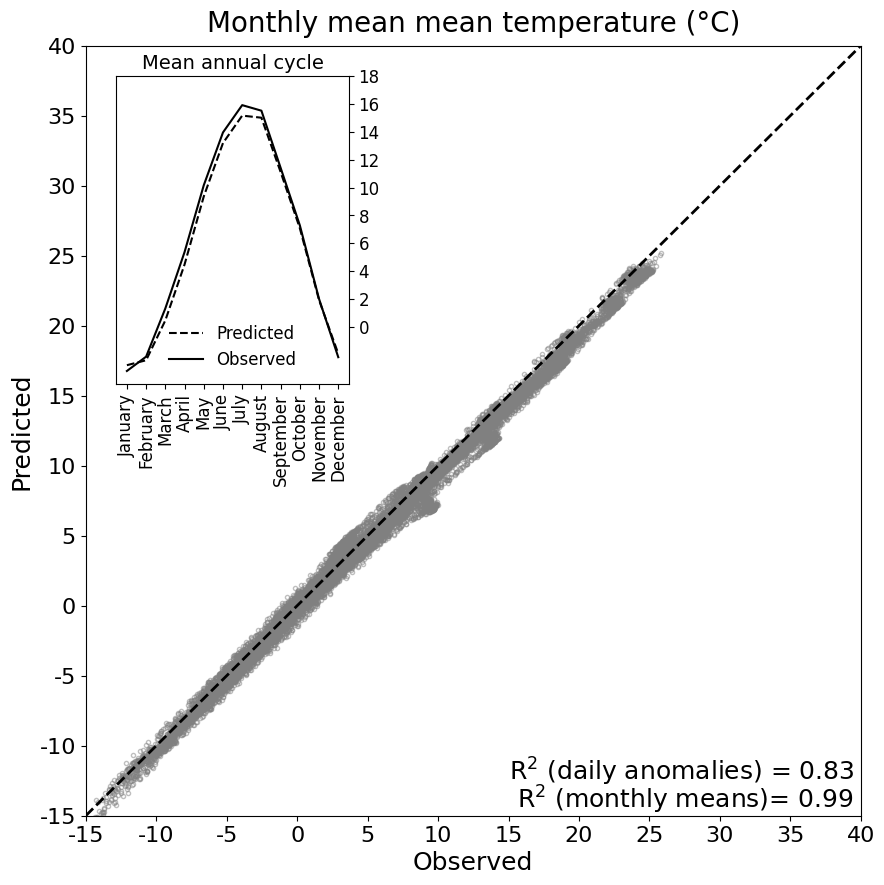

In [19]:
# scatter plot of observations vs. predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot entire dataset
ax.plot(y_true_mv, y_pred_mv, 'o', alpha=.5, markeredgecolor='grey', markerfacecolor='none', markersize=3);

# plot 1:1 mapping line
if PREDICTAND == 'tasmin':
    interval = np.arange(-25, 30, 5)
else:
    interval = np.arange(-15, 45, 5)
ax.plot(interval, interval, color='k', lw=2, ls='--')

# add coefficients of determination
ax.text(interval[-1] - 0.5, interval[0] + 0.5, s='R$^2$ (monthly means)= {:.2f}'.format(r2_mm), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 2.5, s='R$^2$ (daily anomalies) = {:.2f}'.format(r2_anom), ha='right', fontsize=18)


# format axes
ax.set_ylim(interval[0], interval[-1])
ax.set_xlim(interval[0], interval[-1])
ax.set_xticks(interval)
ax.set_xticklabels(interval, fontsize=16)
ax.set_yticks(interval)
ax.set_yticklabels(interval, fontsize=16)
ax.set_xlabel('Observed', fontsize=18)
ax.set_ylabel('Predicted', fontsize=18)
ax.set_title('Monthly mean {} (°C)'.format(NAMES[PREDICTAND]), fontsize=20, pad=10);

# add axis for annual cycle
axins = inset_axes(ax, width="30%", height="40%", loc=2, borderpad=1)
axins.plot(y_pred_ac.values, ls='--', color='k', label='Predicted')
axins.plot(y_true_ac.values, ls='-', color='k', label='Observed')
axins.legend(frameon=False, fontsize=12, loc='lower center');
axins.yaxis.tick_right()
axins.set_yticks(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(0, 20, 2))
axins.set_yticklabels(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(0, 20, 2), fontsize=12)
axins.set_xticks(np.arange(0, 12))
axins.set_xticklabels([calendar.month_name[i + 1] for i in np.arange(0, 12)], rotation=90, fontsize=12)
axins.set_title('Mean annual cycle', fontsize=14, pad=5);

### Mean error (Bias)

Calculate yearly average bias over entire reference period:

In [20]:
# yearly average bias over reference period
y_pred_yearly_avg = y_pred.groupby('time.year').mean(dim='time')
y_true_yearly_avg = y_true.groupby('time.year').mean(dim='time')
bias_yearly_avg = y_pred_yearly_avg - y_true_yearly_avg
print('(Model) Yearly average bias of {}: {:.2f}°C'.format(PREDICTAND, bias_yearly_avg.mean().item()))

(Model) Yearly average bias of tasmean: -0.40°C


### Mean absolute error (MAE)

In [21]:
# mean absolute error over reference period
mae_avg = np.abs(y_pred_yearly_avg - y_true_yearly_avg).mean()
print('(Model) Yearly average MAE of {}: {:.2f}°C'.format(PREDICTAND, mae_avg.mean().item()))

(Model) Yearly average MAE of tasmean: 0.42°C


### Root mean squared error (RMSE)

In [22]:
# root mean squared error over reference period
rmse_avg = np.sqrt(((y_pred_yearly_avg - y_true_yearly_avg) ** 2).mean())
print('(Model) Yearly average RMSE of {}: {:.2f}°C'.format(PREDICTAND, rmse_avg.mean().item()))

(Model) Yearly average RMSE of tasmean: 0.51°C


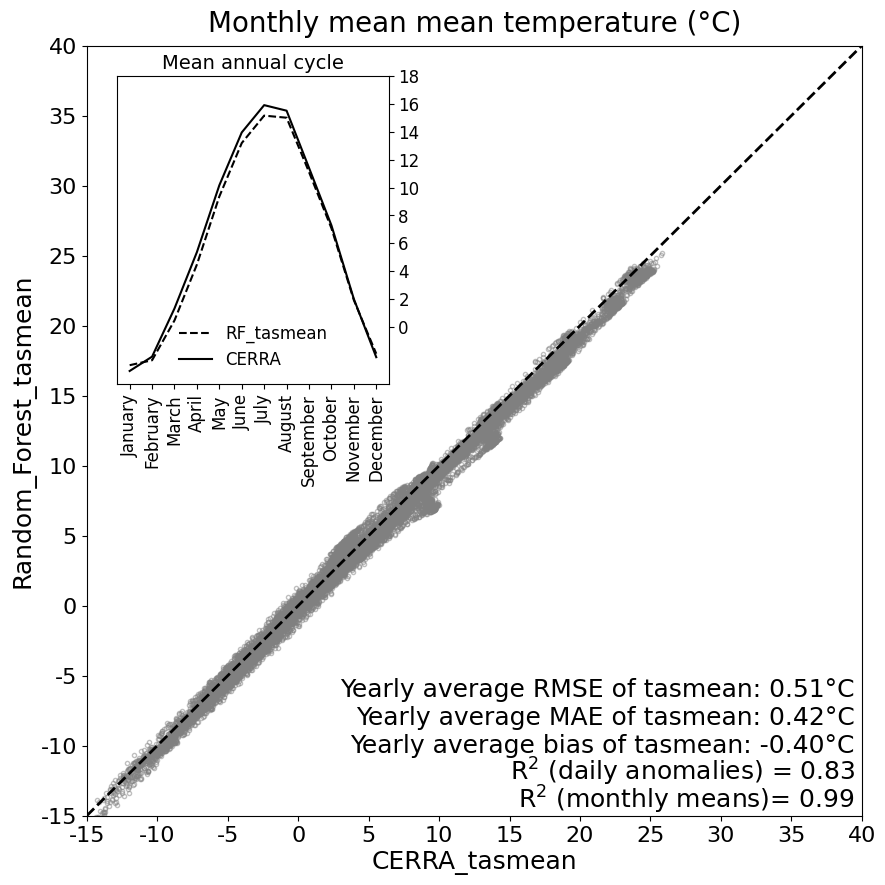

In [26]:
# scatter plot of observations vs. predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot entire dataset
ax.plot(y_true_mv, y_pred_mv, 'o', alpha=.5, markeredgecolor='grey', markerfacecolor='none', markersize=3);

# plot 1:1 mapping line
if PREDICTAND == 'tasmin':
    interval = np.arange(-25, 30, 5)
else:
    interval = np.arange(-15, 45, 5)
ax.plot(interval, interval, color='k', lw=2, ls='--')

# add coefficients of determination
ax.text(interval[-1] - 0.5, interval[0] + 0.5, s='R$^2$ (monthly means)= {:.2f}'.format(r2_mm), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 2.5, s='R$^2$ (daily anomalies) = {:.2f}'.format(r2_anom), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 4.5, s='Yearly average bias of {}: {:.2f}°C'.format(PREDICTAND, bias_yearly_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 6.5, s='Yearly average MAE of {}: {:.2f}°C'.format(PREDICTAND, mae_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 8.5, s='Yearly average RMSE of {}: {:.2f}°C'.format(PREDICTAND, rmse_avg.mean().item()), ha='right', fontsize=18)


# format axes
ax.set_ylim(interval[0], interval[-1])
ax.set_xlim(interval[0], interval[-1])
ax.set_xticks(interval)
ax.set_xticklabels(interval, fontsize=16)
ax.set_yticks(interval)
ax.set_yticklabels(interval, fontsize=16)
ax.set_xlabel('CERRA_tasmean', fontsize=18)
ax.set_ylabel('Random_Forest_tasmean', fontsize=18)
ax.set_title('Monthly mean {} (°C)'.format(NAMES[PREDICTAND]), fontsize=20, pad=10);

# add axis for annual cycle
axins = inset_axes(ax, width="35%", height="40%", loc=2, borderpad=1)
axins.plot(y_pred_ac.values, ls='--', color='k', label='RF_tasmean')
axins.plot(y_true_ac.values, ls='-', color='k', label='CERRA')
axins.legend(frameon=False, fontsize=12, loc='lower center');
axins.yaxis.tick_right()
axins.set_yticks(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(0, 20, 2))
axins.set_yticklabels(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(0, 20, 2), fontsize=12)
axins.set_xticks(np.arange(0, 12))
axins.set_xticklabels([calendar.month_name[i + 1] for i in np.arange(0, 12)], rotation=90, fontsize=12)
axins.set_title('Mean annual cycle', fontsize=14, pad=5);

plt.savefig('mslp.png', dpi=300, bbox_inches='tight')
